<a href="https://colab.research.google.com/github/mintesin/Projects/blob/main/CV_Based%20Network_Performance_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Goal
1. Evaluating the performance and coverage of deployed mobile communication system Network using machine learning model.
2. Such evaluation is done usually using drive testing using locomotives driving to asses the recieved signal strength.
3. Drive testing is time consuming,and cannot handle the complexity of the future complex technologies like 5G.
4. Therefore this project is to simplify the network performance measurement by minimizing loss and the effort ,time consumption and expense in handling more sophesticated technologies.
   

 # Dataset
1. The dataset is from https://ieee-dataport.org/open-access/mobile-communication-system-measurements-and-satellite-images
2. The dataset contains measurements from a deployed LTE-A mobile communication system and corresponding satellite images.
3. The dataset contains
    - Longitude
    - Latitude
    - Speed (in km/h)
    - Distance (in km)
    - Distance_x
    - Distance_y
    - PCI (Integer)
    - PCI_64 (811 MHz base station) (one-hot encoding)
    - PCI_65 (811 MHz base station) (one-hot encoding)
    - PCI_302 (2630 MHz base station) (one-hot encoding)
4. The dataset also contains an image belongs to each geographical locations.Those images are:
    - colored in RGB scale
    - The required and performance measurement values are 
    - SINR (dB)
    - RSRP (dBm)
    - RSRQ (dB)
    - Power/RSSI (dBm)

# Project Goal
1. Error(MSE) is very small as much as possible.
2. computational speed both in training and testing including prediction is fairly important

In [ ]:
import numpy as np
np.random.seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import pandas as pd
import os
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from PIL import Image
from numpy import savetxt
import cv2
from sklearn.decomposition import PCA

In [ ]:
data_x=pd.read_csv("/content/drive/MyDrive/datasets/feature_matrix.csv",delimiter=',')
data_y=pd.read_csv("/content/drive/MyDrive/datasets/output_matrix.csv",delimiter=',')

In [ ]:
data_x.shape,data_y.shape

((57586, 11), (57586, 5))

In [ ]:
#let us merge the features and the target
data_full=pd.concat([data_x,data_y],axis=1)

In [ ]:
data_full.head()

,Unnamed: 0,Longitude,Latitude,Speed,Distance,Distance_x,Distance_y,PCI,PCI_64,PCI_65,PCI_302,Unnamed: 0,SINR,RSRP,RSRQ,Power
0,0,12.520112,55.780073,21.51,0.553064,-0.004597,-0.003369,64,1,0,0,0,16.18,-75.44,-13.36,-55.42
1,1,12.520119,55.780071,20.93,0.553104,-0.004599,-0.003362,64,1,0,0,1,16.18,-75.44,-13.36,-55.42
2,2,12.520127,55.780070,20.36,0.553016,-0.004600,-0.003354,64,1,0,0,2,16.18,-75.44,-13.36,-55.42
3,3,12.520135,55.780068,19.78,0.553033,-0.004602,-0.003346,64,1,0,0,3,16.18,-75.44,-13.36,-55.42
4,4,12.520142,55.780067,19.21,0.552970,-0.004603,-0.003339,64,1,0,0,4,16.18,-75.44,-13.36,-55.42


# 1. EXPLORATORY DATA ANALYSIS

In [ ]:
del data_full['Unnamed: 0']
data_full.columns

Index(['Longitude', 'Latitude', 'Speed', 'Distance', 'Distance_x',
       'Distance_y', 'PCI', 'PCI_64', 'PCI_65', 'PCI_302', 'SINR', 'RSRP',
       'RSRQ', 'Power'],
      dtype='object')

In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57586 entries, 0 to 57585
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Longitude   57586 non-null  float64
 1   Latitude    57586 non-null  float64
 2   Speed       57586 non-null  float64
 3   Distance    57586 non-null  float64
 4   Distance_x  57586 non-null  float64
 5   Distance_y  57586 non-null  float64
 6   PCI         57586 non-null  int64  
 7   PCI_64      57586 non-null  int64  
 8   PCI_65      57586 non-null  int64  
 9   PCI_302     57586 non-null  int64  
 10  SINR        57586 non-null  float64
 11  RSRP        57586 non-null  float64
 12  RSRQ        57586 non-null  float64
 13  Power       57586 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 6.2 MB


1. We have 14 columns without null entries.
2. All of the features are numerals having int64 and float64 data types.
3. Each row represents one base stations of interms of all forteen features
4. Out of 14 columns , four of them are target columns and the rest are training features

In [ ]:
#we can understand 'PCI' feature is categorical and 
# let us see the number of categories
data_full['PCI'].value_counts()

302    23616
65     22107
64     11863
Name: PCI, dtype: int64

We can see that the column PCI is categorical into PCI_302, PCI_65 AND PCI_64 and there are three OneHotencoded columns of PCI.Therefore we don't need the "PCI"

In [ ]:
#since 'PCI' is there in our dataset as one hot encoded
#we can remove it from the dataset
data_m=data_full.drop('PCI',axis=1)
data_m.head()

,Longitude,Latitude,Speed,Distance,Distance_x,Distance_y,PCI_64,PCI_65,PCI_302,SINR,RSRP,RSRQ,Power
0,12.520112,55.780073,21.51,0.553064,-0.004597,-0.003369,1,0,0,16.18,-75.44,-13.36,-55.42
1,12.520119,55.780071,20.93,0.553104,-0.004599,-0.003362,1,0,0,16.18,-75.44,-13.36,-55.42
2,12.520127,55.780070,20.36,0.553016,-0.004600,-0.003354,1,0,0,16.18,-75.44,-13.36,-55.42
3,12.520135,55.780068,19.78,0.553033,-0.004602,-0.003346,1,0,0,16.18,-75.44,-13.36,-55.42
4,12.520142,55.780067,19.21,0.552970,-0.004603,-0.003339,1,0,0,16.18,-75.44,-13.36,-55.42


In [ ]:
data_m.describe()

,Longitude,Latitude,Speed,Distance,Distance_x,Distance_y,PCI_64,PCI_65,PCI_302,SINR,RSRP,RSRQ,Power
count,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000,57586.000000
mean,12.520284,55.785720,19.913798,0.493680,0.001050,-0.003197,0.206005,0.383895,0.410100,6.635888,-96.391704,-18.841786,-73.222995
std,0.004109,0.003827,12.112611,0.239163,0.003827,0.004109,0.404438,0.486337,0.491856,11.013139,18.170756,4.929765,17.762641
min,12.509892,55.775472,0.000000,0.007852,-0.009198,-0.013589,0.000000,0.000000,0.000000,-20.880000,-142.950000,-42.980000,-123.520000
25%,12.517098,55.783061,12.160000,0.355346,-0.001609,-0.006383,0.000000,0.000000,0.000000,2.490000,-108.060000,-21.850000,-84.470000
50%,12.520319,55.785284,16.730000,0.505009,0.000614,-0.003162,0.000000,0.000000,0.000000,6.780000,-95.680000,-17.520000,-71.960000
75%,12.523360,55.788762,26.500000,0.612500,0.004092,-0.000121,0.000000,1.000000,1.000000,13.680000,-83.950000,-15.140000,-61.370000
max,12.530001,55.797695,57.560000,1.501111,0.013025,0.006520,1.000000,1.000000,1.000000,35.510000,-53.470000,-12.580000,-32.500000


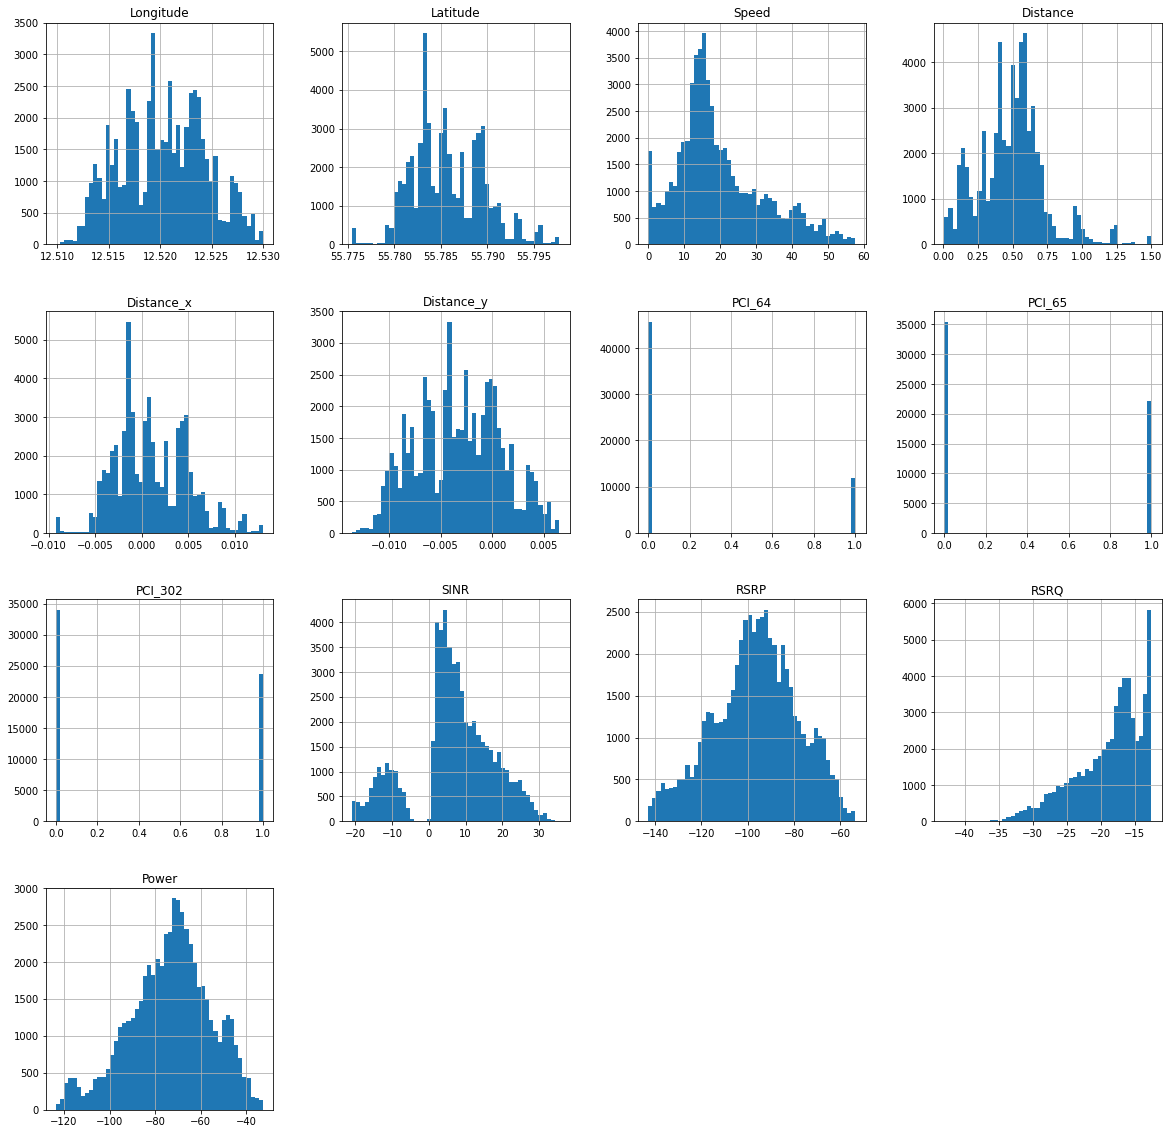

In [ ]:
data_m.hist(bins=50,figsize=(20,20))
plt.show()

1. We can see that most of our features are nearly have gaussian distribution even though there is a little skewness in most of them.
2. PCI categories are either fall into one or zero because of OneHot encoding.
3. RSRQ has skewness to the right(towards larger values).
4. SNR has almost zero values in the interval of (-10,0) 
   

In our dataset we have geographical data which are latitude and longitude features.So,let us visualize it to get an idea of the kind of geographical area we are dealing with.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


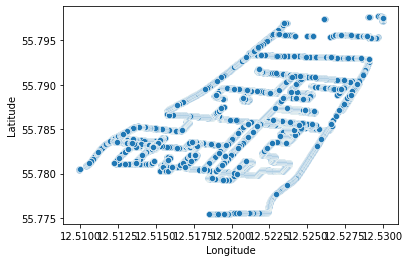

In [ ]:
#latitude and lingitude scatter plot
sns.scatterplot(data_m['Longitude'],data_m['Latitude'])

1. From this geographical shape we can guess that the area might be town or city or highly populated area.
2. If so there might be big biuldings which may block the signal from traveling without hindrance.
3. The probability of getting noise and crosstalks might be high.
   

# which area has high amount of SINR?

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


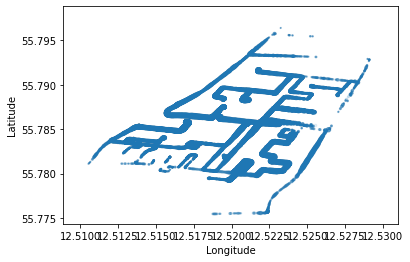

In [ ]:
#IN THE FOLLOWING GRAPH THE RADIUS OF THE SMALL CIRCLES IS THE LEVEL SINR OF THE SIGNAL
#AS THE SINR DROPS THE CIRCLES GETS SMALLER AND SMALLER
data_m.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1,s=data_m['SINR'])

1.Around the center the graph is bold with alpha=0.1 and the level of boldness shows the magnitude of SNR ,which means there might be a base station aruond center area.
2. As distance increases the SNR decreases as the graph gets thinner and thinner.
3. We can classify our datapoints based on thier distance and take their categories as a feature later.

# Looking for correlation!!!

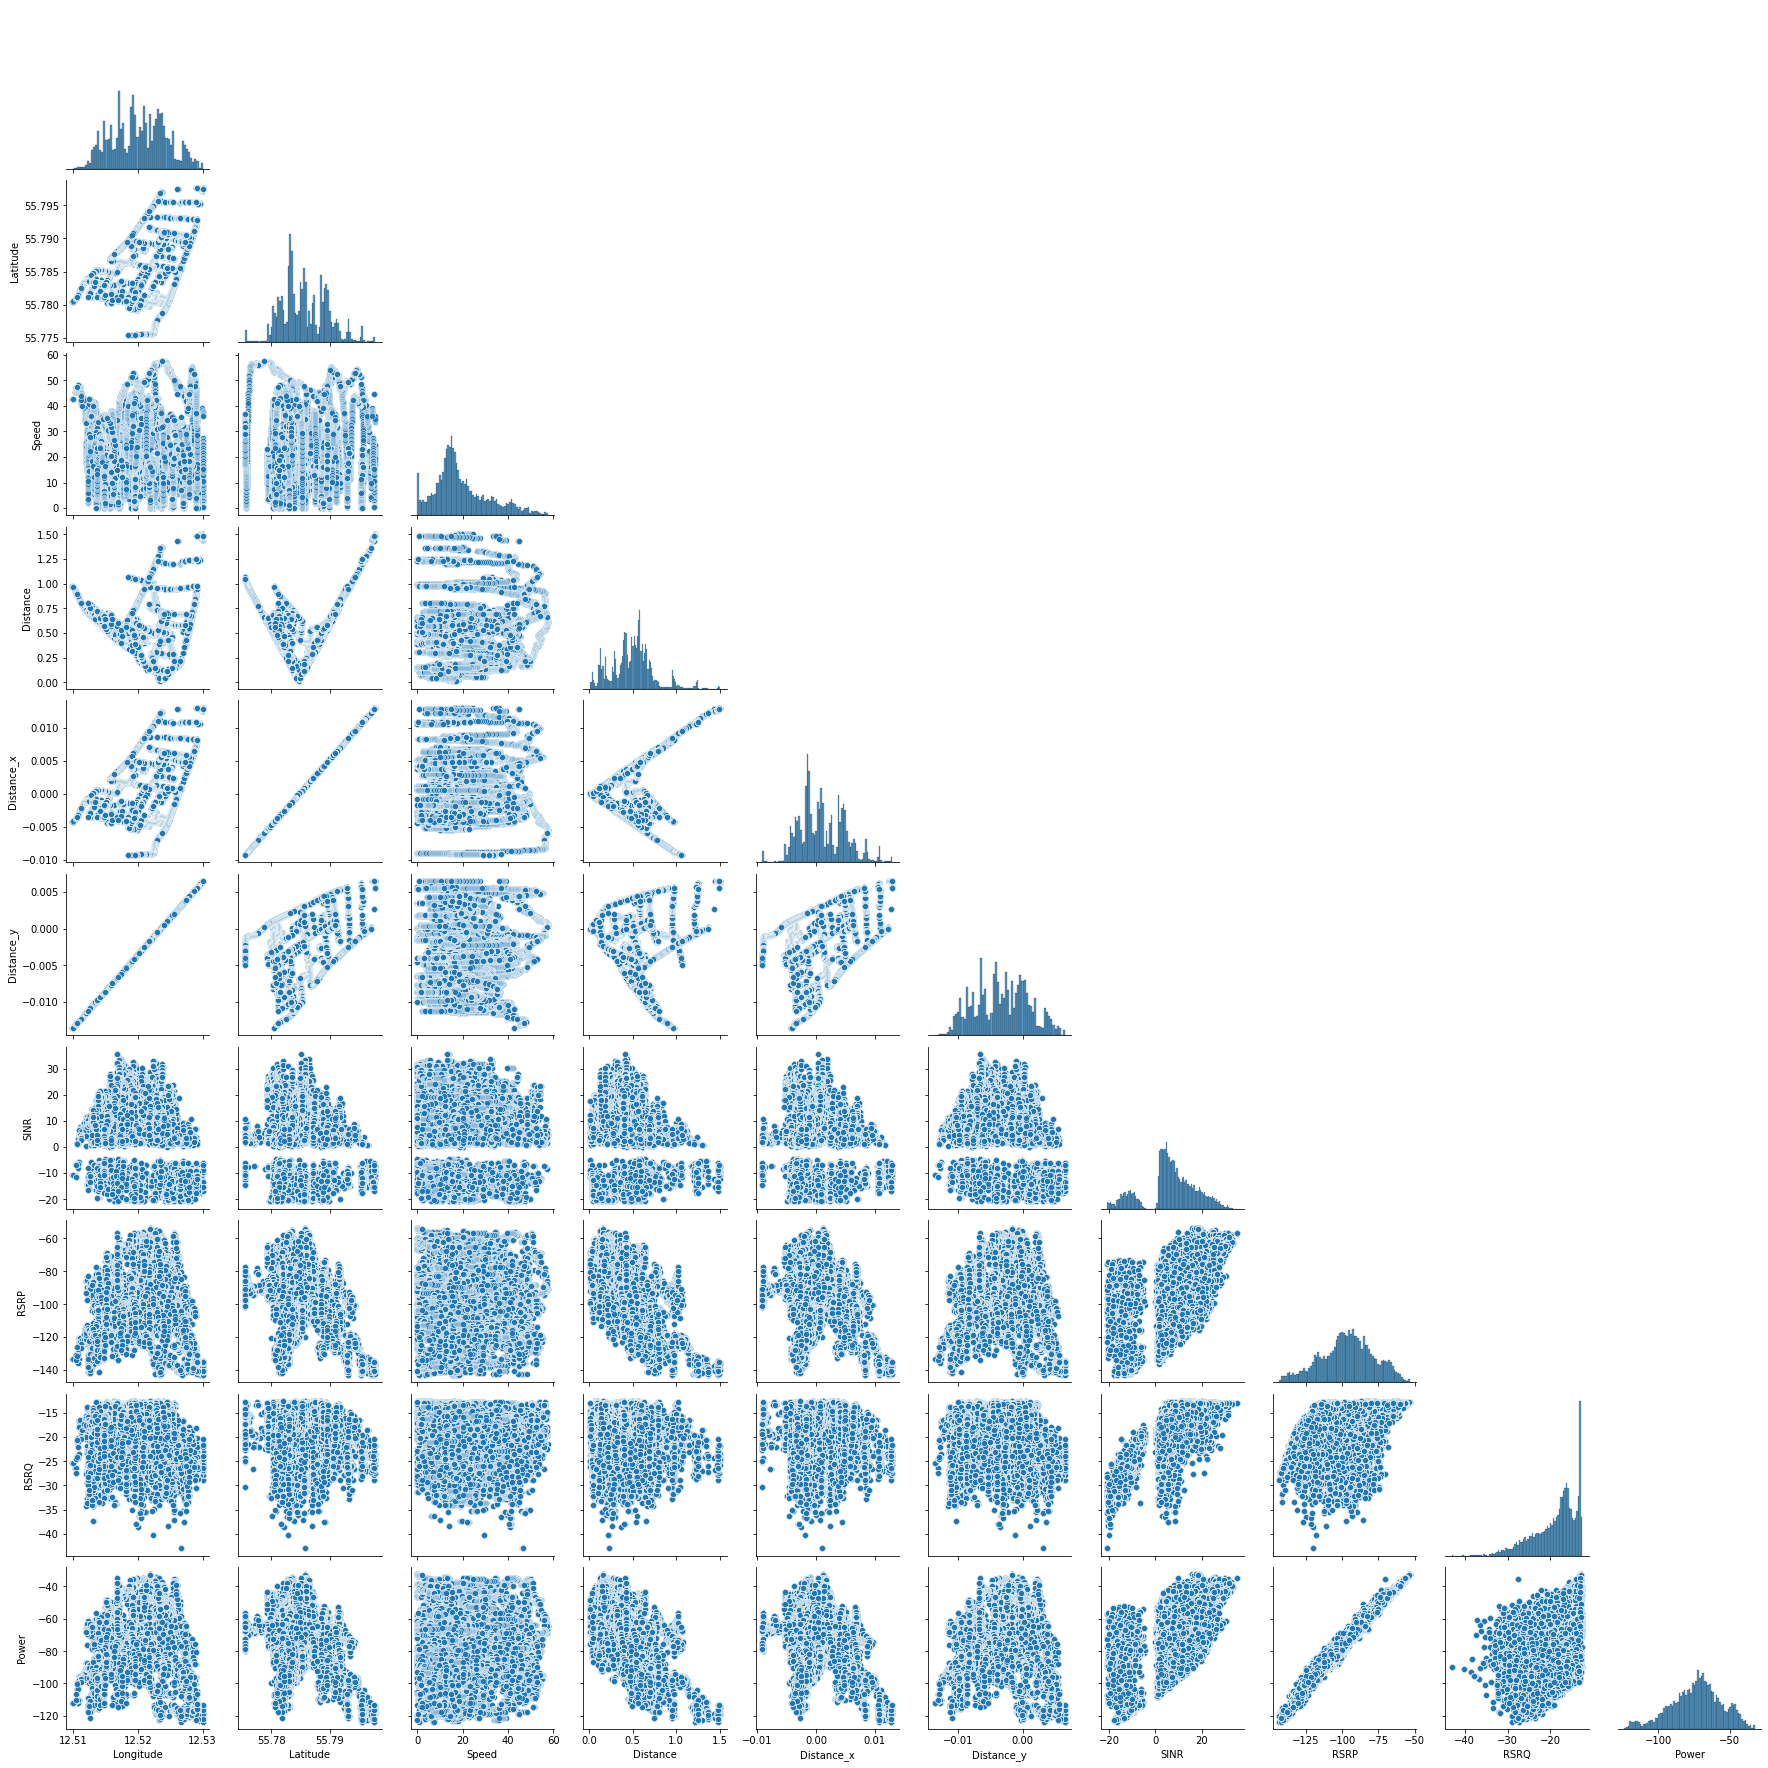

In [ ]:
columns=['Longitude','Latitude','Speed','Distance','Distance_x','Distance_y','SINR','RSRP','RSRQ','Power']
sns.pairplot(data_m[columns],corner=True)
plt.show()

1. We can see that Distance_x and latitude are highly correlated.Therefore we can eliminate one of the two.
2. We can observe that Distance_y and longitude are highly correlated. Therefore we can eliminate one of the two for ease of computation.
3. we can also observe that there is correlation between RSRP and power. 

In [ ]:
#let us examine the correaltion of each feature with the outputs
#The correlation method is the deafult of dataframe.corr which is pearson coorelation
column=['SINR','RSRP','RSRQ','Power']
correlation_matrix=data_m.corr()
pd.DataFrame(correlation_matrix[list(data_m.columns)],index=column,columns=data_m.columns)
   

,Longitude,Latitude,Speed,Distance,Distance_x,Distance_y,PCI_64,PCI_65,PCI_302,SINR,RSRP,RSRQ,Power
SINR,-0.163785,-0.053775,-0.003037,-0.290509,-0.053775,-0.163785,0.020680,-0.035896,0.018489,1.000000,0.487068,0.777413,0.523978
RSRP,0.035385,-0.319283,-0.099723,-0.594784,-0.319283,0.035385,0.322537,0.452499,-0.712634,0.487068,1.000000,0.456899,0.990999
RSRQ,-0.166068,-0.040928,-0.133844,-0.169552,-0.040928,-0.166068,0.071471,0.027344,-0.085805,0.777413,0.456899,1.000000,0.444770
Power,0.033721,-0.315157,-0.058617,-0.615837,-0.315157,0.033721,0.307227,0.442786,-0.690441,0.523978,0.990999,0.444770,1.000000


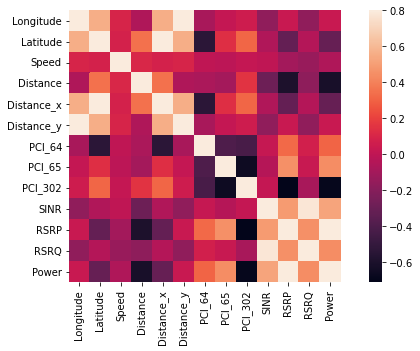

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix,vmax=.8,square=True,)
plt.show()

1. It is understandable that distance_x and distance_y have nearly the same state of correlation with the outputs because they are highly correlated.This strengthen the idea that they can be removed.
2. Again the feature Distance is almost uncorrelated or negatively correlated with all of the outputs.So it is better to remove it.
   

In [ ]:
col=['Distance','Distance_x','Distance_y']
data_m=data_m.drop(col,axis=1)
data_m.columns  


Index(['Longitude', 'Latitude', 'Speed', 'PCI_64', 'PCI_65', 'PCI_302', 'SINR',
       'RSRP', 'RSRQ', 'Power'],
      dtype='object')

# IMAGE DATASET

We are going to consider(experiment) for the best of our final result in two ways
1. First we will convert all images into gray scale and then change it in to the dataframe using numpy array and we will concatenate with the rest of our dataset
2. Second  we will detect the images edges and then convert it to dataframe using numpy array and we will concatenate it with the rest of our dataset 
Then we will train our models on both dataset to get the best one

# Without Edge detection

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image

def produce_im_array(directory):
    #creating empty nd numpy array
    m=np.empty((900,))
    for image in os.listdir(directory):
        h=image.split('.')
        if(h[1]=='png'): #checking whther our image is png filetype
            im=os.path.join(directory,image)
            #open the image from the directory 
            #convert to the gray scale from the RGB  scale
            #Resize it to 30 by 30 pixels
            image=Image.open(im).convert('L').resize((30,30),resample=0)
            #change the image into the one dimensional nmpy array
            image_array=np.array(image).flatten(order='C')
            #stacking our images into the array 
            m=np.vstack((m,image_array))
        
        else:continue
    return m
h=produce_im_array('IMAGES')


In [ ]:
image_df=pd.DataFrame(h)
image_df.to_csv('/content/drive/MyDrive/datasets/images_data.csv')

In [ ]:
image_df=pd.read_csv('/content/drive/MyDrive/datasets/images_data.csv',delimiter=',')

In [ ]:
image_df.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,0,3.658315e-312,3.658335e-312,0.0,0.0,3.649833e-312,1.500089e+248,1.677515e+243,2.513135e+180,3.488697e-143,6.199419e-71,4.475939e-91,4.475938e-91,4.475938e-91,4.475938e-91,4.475938e-91,4.475938e-91,4.475938e-91,4.475938e-91,4.475938e-91,1.060329e+136,9.021934e+217,9.162814e-72,6.296159e+69,1.677515e+243,9.459563e-76,6.013470e-154,6.013470e-154,6.013470e-154,6.013470e-154,9.853306e+165,1.098654e+248,6.964076e+252,1.977178e+161,6.016452e-154,9.898036e+164,2.205932e-85,4.076738e+233,4.038756e+175,2.586725e+161,...,6.125739e-154,2.951521e-75,6.125729e-154,5.860315e+135,9.021934e+217,2.135946e+257,1.741606e-152,6.199419e-71,2.951540e-75,5.969715e+135,9.021934e+217,1.421379e-76,2.951641e-75,4.674851e-62,9.898036e+164,9.162814e-72,1.626911e+219,1.674379e+243,9.898036e+164,9.162814e-72,5.928632e-114,9.459563e-76,1.614106e+132,7.295301e+175,1.614106e+132,9.898036e+164,1.033076e+136,9.021934e+217,1.614106e+132,2.361481e+257,2.951625e-75,2.134126e+257,6.610204e-62,9.162814e-72,2.951479e-75,4.778820e+180,4.981315e+151,2.136235e+257,1.697250e+137,1.435735e-23
1,1,7.600000e+01,5.200000e+01,71.0,73.0,9.500000e+01,7.900000e+01,1.080000e+02,9.800000e+01,9.300000e+01,8.600000e+01,1.760000e+02,1.320000e+02,1.560000e+02,1.410000e+02,1.290000e+02,1.280000e+02,2.500000e+01,7.600000e+01,7.000000e+01,1.910000e+02,8.100000e+01,6.100000e+01,8.100000e+01,1.290000e+02,5.700000e+01,7.000000e+01,1.230000e+02,1.950000e+02,1.170000e+02,1.960000e+02,7.700000e+01,6.100000e+01,9.200000e+01,9.700000e+01,9.800000e+01,9.600000e+01,6.700000e+01,1.020000e+02,1.170000e+02,...,6.400000e+01,9.900000e+01,1.020000e+02,9.900000e+01,9.000000e+01,8.300000e+01,9.000000e+01,9.800000e+01,1.110000e+02,1.510000e+02,1.140000e+02,1.140000e+02,1.140000e+02,1.120000e+02,1.150000e+02,1.150000e+02,1.110000e+02,1.050000e+02,2.140000e+02,1.880000e+02,2.080000e+02,2.230000e+02,1.300000e+02,2.010000e+02,2.000000e+02,2.200000e+02,2.120000e+02,1.140000e+02,4.700000e+01,9.300000e+01,1.040000e+02,1.270000e+02,2.100000e+02,1.940000e+02,2.150000e+02,2.170000e+02,2.140000e+02,2.150000e+02,2.130000e+02,2.130000e+02
2,2,7.400000e+01,6.300000e+01,72.0,64.0,9.700000e+01,6.600000e+01,1.100000e+02,9.600000e+01,1.020000e+02,9.300000e+01,1.680000e+02,1.140000e+02,1.170000e+02,1.270000e+02,1.310000e+02,1.390000e+02,2.800000e+01,7.200000e+01,7.100000e+01,1.520000e+02,8.300000e+01,6.600000e+01,7.400000e+01,1.660000e+02,6.300000e+01,5.700000e+01,9.400000e+01,1.940000e+02,1.570000e+02,1.060000e+02,5.500000e+01,6.700000e+01,9.500000e+01,9.600000e+01,9.800000e+01,9.000000e+01,7.400000e+01,1.000000e+02,1.160000e+02,...,7.000000e+01,9.700000e+01,1.060000e+02,1.000000e+02,8.700000e+01,9.000000e+01,9.100000e+01,1.030000e+02,1.070000e+02,1.520000e+02,1.140000e+02,1.150000e+02,1.140000e+02,1.150000e+02,1.130000e+02,1.130000e+02,1.160000e+02,1.120000e+02,2.080000e+02,2.140000e+02,2.050000e+02,2.180000e+02,1.250000e+02,2.040000e+02,2.010000e+02,2.140000e+02,2.200000e+02,1.160000e+02,4.100000e+01,7.900000e+01,1.130000e+02,1.380000e+02,2.120000e+02,2.060000e+02,2.180000e+02,2.180000e+02,2.170000e+02,2.120000e+02,2.230000e+02,2.180000e+02
3,3,8.700000e+01,7.200000e+01,61.0,65.0,6.500000e+01,1.010000e+02,7.200000e+01,1.050000e+02,9.700000e+01,1.100000e+02,9.100000e+01,1.690000e+02,1.330000e+02,1.100000e+02,1.280000e+02,1.270000e+02,1.390000e+02,3.400000e+01,7.500000e+01,7.300000e+01,9.400000e+01,8.200000e+01,7.500000e+01,7.200000e+01,1.730000e+02,7.700000e+01,5.300000e+01,8.500000e+01,1.920000e+02,2.240000e+02,9.500000e+01,6.000000e+01,6.500000e+01,8.100000e+01,9.600000e+01,9.900000e+01,8.500000e+01,7.900000e+01,9.600000e+01,...,1.550000e+02,6.300000e+01,9.700000e+01,9.900000e+01,1.010000e+02,9.200000e+01,7.700000e+01,9.300000e+01,9.600000e+

In [ ]:
#since the first row was added during the conversion of 
#image to the csv file it has to be removed
del image_df['Unnamed: 0']


In [ ]:
image_df=image_df.drop(0)
image_df.head(3)
print(image_df.shape)

(57586, 900)


In [ ]:
#for ease of computation and siplicity for the model 
#to fit the image data we normlize it by deviding by 255
image_df=image_df/255.0


# With edge detection

In [ ]:
directory='IMAGES'
def image_con_array(directory):
    #function to detect the edges and convert it the numpy stack of arrays
    im_arrays=np.empty((900,))
    for image in os.listdir(directory):
        h=image.split('.')
        if (h[1]=='png'):#check whether the image is '.png' format
            im=os.path.join(directory,image)
            ima=cv2.imread(im)#reading image 
            gray_scale=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)#convert to grayscale
            gray_blurr=cv2.medianBlur(gray_scale,3)#blurring with median blurr
            thr=cv2.adaptiveThreshold(gray_blurr,100,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,9,9)
            #detecting adaptive thresholding
             #with 100 being maximum value
             #9X9 block size to be considered for thresholding
            
            thr=cv2.resize(thr,(30,30))
            im_ara=np.array(thr).flatten(order='C' )/100.0
            
            im_arrays=np.vstack((im_arrays,im_ara))
        else:continue
    return im_arrays
im_data_2=image_con_array(directory)

In [ ]:
im_dataframe=pd.DataFrame(im_data_2)
im_dataframe.to_csv('/content/drive/MyDrive/datasets/imdataframe.csv')

In [ ]:
im_dataframe=pd.read_csv('/content/drive/MyDrive/datasets/imdataframe.csv',delimiter=',')

In [ ]:
im_dataframe.shape

(57587, 901)

In [ ]:
im_dataframe.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,0,2.448542e-312,2.448287e-312,0.00,2.448543e-312,4.940656e-324,2.448543e-312,4.940656e-324,2.448543e-312,1.185758e-322,2.448636e-312,2.440295e-312,0.00,1.136351e-322,1.909796e-313,6.153788e-313,2.448635e-312,4.940656e-324,0.00,2.121996e-313,5.304989e-313,4.940656e-324,2.448543e-312,2.440295e-312,2.447967e-312,2.440295e-312,2.448543e-312,5.517189e-313,7.426985e-313,0.0,0.00,2.440295e-312,2.448543e-312,2.448543e-312,2.448543e-312,2.121996e-313,7.639185e-313,4.243992e-313,2.448543e-312,2.448543e-312,...,6.013470e-154,3.943571e+180,1.440340e+214,2.301877e+161,5.981576e-154,1.086139e-153,5.147567e+151,1.967182e-153,9.227129e+242,1.384968e+219,3.170959e+180,3.591084e+246,4.895842e-85,6.013470e-154,6.090828e+247,1.631125e-27,1.469234e+195,4.890993e+199,7.478250e+247,4.909001e+252,3.101323e+169,2.347861e+251,6.013470e-154,6.047090e+247,9.816764e+252,6.787540e+199,6.218329e+175,7.372453e+228,1.979087e+161,1.285154e+248,1.695936e-152,5.303782e+180,6.013470e-154,2.348396e+251,1.123202e+219,1.384968e+219,2.321610e-152,9.302817e+242,6.013470e-154,4.995857e-119
1,1,1.000000e+00,4.600000e-01,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.700000e-01,1.000000e+00,1.000000e+00,0.63,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.300000e-01,1.000000e+00,0.0,1.00,9.300000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e-01,1.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e-01,7.600000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.700000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
2,2,1.000000e+00,7.700000e-01,1.00,1.000000e+00,1.000000e+00,1.000000e-01,1.000000e+00,1.000000e+00,9.900000e-01,1.000000e+00,1.000000e+00,0.00,3.600000e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.3,0.23,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.800000e-01,3.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,2.300000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
3,3,1.000000e+00,1.000000e+00,1.00,1.000000e+00,9.200000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.17,1.000000e+00,1.000000e+00,1.000000e+00,9.900000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.300000e-01,0.000000e+00,1.0,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.300000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.00000

In [ ]:
#since the first row was added during the conversion of 
#image to the csv file it has to be removed
del im_dataframe['Unnamed: 0']

In [ ]:
#the first row is from empy numpy array we used for stacking so we have to elimante it
#im_dataframe=im_dataframe.drop(0)
im_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,2.448542e-312,2.448287e-312,0.00,2.448543e-312,4.940656e-324,2.448543e-312,4.940656e-324,2.448543e-312,1.185758e-322,2.448636e-312,2.440295e-312,0.00,1.136351e-322,1.909796e-313,6.153788e-313,2.448635e-312,4.940656e-324,0.00,2.121996e-313,5.304989e-313,4.940656e-324,2.448543e-312,2.440295e-312,2.447967e-312,2.440295e-312,2.448543e-312,5.517189e-313,7.426985e-313,0.0,0.00,2.440295e-312,2.448543e-312,2.448543e-312,2.448543e-312,2.121996e-313,7.639185e-313,4.243992e-313,2.448543e-312,2.448543e-312,0.0,...,6.013470e-154,3.943571e+180,1.440340e+214,2.301877e+161,5.981576e-154,1.086139e-153,5.147567e+151,1.967182e-153,9.227129e+242,1.384968e+219,3.170959e+180,3.591084e+246,4.895842e-85,6.013470e-154,6.090828e+247,1.631125e-27,1.469234e+195,4.890993e+199,7.478250e+247,4.909001e+252,3.101323e+169,2.347861e+251,6.013470e-154,6.047090e+247,9.816764e+252,6.787540e+199,6.218329e+175,7.372453e+228,1.979087e+161,1.285154e+248,1.695936e-152,5.303782e+180,6.013470e-154,2.348396e+251,1.123202e+219,1.384968e+219,2.321610e-152,9.302817e+242,6.013470e-154,4.995857e-119
1,1.000000e+00,4.600000e-01,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.700000e-01,1.000000e+00,1.000000e+00,0.63,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.300000e-01,1.000000e+00,0.0,1.00,9.300000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e-01,1.000000e+00,1.000000e+00,0.0,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e-01,7.600000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.700000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
2,1.000000e+00,7.700000e-01,1.00,1.000000e+00,1.000000e+00,1.000000e-01,1.000000e+00,1.000000e+00,9.900000e-01,1.000000e+00,1.000000e+00,0.00,3.600000e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.3,0.23,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.800000e-01,3.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,2.300000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
3,1.000000e+00,1.000000e+00,1.00,1.000000e+00,9.200000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.17,1.000000e+00,1.000000e+00,1.000000e+00,9.900000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.300000e-01,0.000000e+00,1.0,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,...,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.300000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.00000

In [ ]:
im_dataframe=im_dataframe.drop(0)
im_dataframe.head(3)
print(im_dataframe.shape)

(57586, 900)


In [ ]:
im_dataframe.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
1,1.0,0.46,1.0,1.0,1.00,1.0,1.0,1.0,0.77,1.0,1.0,0.63,1.00,1.0,1.0,1.0,0.0,1.00,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.63,1.0,0.0,1.00,0.93,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.3,0.76,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.77,0.00,0.0,0.0,0.23,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,0.77,1.0,1.0,1.00,0.1,1.0,1.0,0.99,1.0,1.0,0.00,0.36,1.0,1.0,1.0,0.0,1.00,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.00,1.0,0.3,0.23,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.3,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.00,0.00,0.0,0.1,0.23,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.00,1.0,1.0,0.92,1.0,0.0,1.0,1.00,1.0,1.0,1.00,0.00,0.0,1.0,1.0,1.0,0.17,1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,0.63,0.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,0.23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99,1.0,0.9,1.0,1.0,0.0,1.0,1.0,1.0,1.00,0.49,0.0,0.0,0.23,0.62,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# DATA PREPROCESSING

In [ ]:
#let us find for the NUll
data_m.isnull().sum()

Longitude    0
Latitude     0
Speed        0
PCI_64       0
PCI_65       0
PCI_302      0
SINR         0
RSRP         0
RSRQ         0
Power        0
dtype: int64

OurDataset has no any null points

In [ ]:
#Let us find duplicates if there are any
data_m.duplicated().sum()

444

2. We can see that there are 444 points duplicated.But from the expertise knowledge we know that if two points there are closer to each other they might have equal measure of signal.
3. when we add image data into this data these duplicated ones might vanish because of thier distance

In [ ]:
#Now let us separete our data features and our targets
data_mx=data_m.iloc[:,0:6]
data_my=data_m.iloc[:,6:]


In [ ]:
data_mx.shape,data_my.shape

((57586, 6), (57586, 4))

In [ ]:
column_x=['Longitude', 'Latitude', 'Speed', 'PCI_64', 'PCI_65', 'PCI_302']
column_y=['SINR','RSRP','RSRQ' ,'Power']
data_mx=pd.DataFrame(data_mx,columns=column_x)
data_my=pd.DataFrame(data_my,columns=column_y)


In [ ]:
data_mx.head(3)

,Longitude,Latitude,Speed,PCI_64,PCI_65,PCI_302
0,12.520112,55.780073,21.51,1,0,0
1,12.520119,55.780071,20.93,1,0,0
2,12.520127,55.780070,20.36,1,0,0


In [ ]:
data_my.head(3)

,SINR,RSRP,RSRQ,Power
0,16.18,-75.44,-13.36,-55.42
1,16.18,-75.44,-13.36,-55.42
2,16.18,-75.44,-13.36,-55.42


In [ ]:
from sklearn.preprocessing import StandardScaler
#since or dataset(except image data) is not standardized we have to standardized 
#The columns to be standardized are Longitude,Latitude,Speed
#One hot encoded PCI data is categorical we don't need to standardize it
scaler=StandardScaler()
d=data_mx[['Longitude','Latitude','Speed']]
f=data_mx[['PCI_64','PCI_65','PCI_302']]
d=scaler.fit_transform(d)
d=pd.DataFrame(d,columns=['Longitude','Latitude','Speed'])
data_mx=pd.concat([d,f],axis=1)


In [ ]:
data_mx.head(5)

,Longitude,Latitude,Speed,PCI_64,PCI_65,PCI_302
0,-0.041879,-1.475507,0.131781,1,0,0
1,-0.040176,-1.476030,0.083897,1,0,0
2,-0.038229,-1.476291,0.036838,1,0,0
3,-0.036282,-1.476814,-0.011046,1,0,0
4,-0.034579,-1.477075,-0.058105,1,0,0


In [ ]:
image_df= image_df.reset_index()
del image_df['index']
print(image_df.shape)
image_df.head(4)

(57586, 900)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,76.0,52.0,71.0,73.0,95.0,79.0,108.0,98.0,93.0,86.0,176.0,132.0,156.0,141.0,129.0,128.0,25.0,76.0,70.0,191.0,81.0,61.0,81.0,129.0,57.0,70.0,123.0,195.0,117.0,196.0,77.0,61.0,92.0,97.0,98.0,96.0,67.0,102.0,117.0,77.0,...,64.0,99.0,102.0,99.0,90.0,83.0,90.0,98.0,111.0,151.0,114.0,114.0,114.0,112.0,115.0,115.0,111.0,105.0,214.0,188.0,208.0,223.0,130.0,201.0,200.0,220.0,212.0,114.0,47.0,93.0,104.0,127.0,210.0,194.0,215.0,217.0,214.0,215.0,213.0,213.0
1,74.0,63.0,72.0,64.0,97.0,66.0,110.0,96.0,102.0,93.0,168.0,114.0,117.0,127.0,131.0,139.0,28.0,72.0,71.0,152.0,83.0,66.0,74.0,166.0,63.0,57.0,94.0,194.0,157.0,106.0,55.0,67.0,95.0,96.0,98.0,90.0,74.0,100.0,116.0,73.0,...,70.0,97.0,106.0,100.0,87.0,90.0,91.0,103.0,107.0,152.0,114.0,115.0,114.0,115.0,113.0,113.0,116.0,112.0,208.0,214.0,205.0,218.0,125.0,204.0,201.0,214.0,220.0,116.0,41.0,79.0,113.0,138.0,212.0,206.0,218.0,218.0,217.0,212.0,223.0,218.0
2,87.0,72.0,61.0,65.0,65.0,101.0,72.0,105.0,97.0,110.0,91.0,169.0,133.0,110.0,128.0,127.0,139.0,34.0,75.0,73.0,94.0,82.0,75.0,72.0,173.0,77.0,53.0,85.0,192.0,224.0,95.0,60.0,65.0,81.0,96.0,99.0,85.0,79.0,96.0,119.0,...,155.0,63.0,97.0,99.0,101.0,92.0,77.0,93.0,96.0,110.0,115.0,114.0,114.0,116.0,114.0,110.0,127.0,119.0,87.0,215.0,200.0,213.0,217.0,141.0,203.0,193.0,216.0,209.0,114.0,46.0,77.0,110.0,125.0,209.0,197.0,212.0,217.0,213.0,220.0,213.0
3,129.0,76.0,115.0,185.0,115.0,94.0,123.0,144.0,113.0,115.0,85.0,93.0,88.0,102.0,130.0,133.0,135.0,132.0,89.0,116.0,113.0,134.0,174.0,178.0,180.0,176.0,170.0,172.0,177.0,183.0,85.0,86.0,113.0,143.0,99.0,112.0,83.0,118.0,101.0,149.0,...,132.0,113.0,127.0,23.0,27.0,29.0,42.0,27.0,55.0,83.0,154.0,97.0,95.0,74.0,95.0,80.0,73.0,54.0,184.0,98.0,125.0,216.0,171.0,217.0,217.0,205.0,213.0,215.0,222.0,222.0,135.0,124.0,124.0,141.0,155.0,162.0,95.0,166.0,154.0,99.0


In [ ]:
im_dataframe= im_dataframe.reset_index()
del im_dataframe['index']
print(im_dataframe.shape)
im_dataframe.head(4)

(57586, 900)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,1.0,0.46,1.00,1.0,1.00,1.0,1.0,1.0,0.77,1.0,1.0,0.63,1.00,1.0,1.00,1.00,0.0,1.00,1.00,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.63,1.00,0.0,1.00,0.93,1.0,1.0,1.0,1.0,1.0,0.7,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.3,0.76,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.0,1.0,0.00,1.0,1.0,1.0,1.0,0.77,0.00,0.0,0.0,0.23,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.77,1.00,1.0,1.00,0.1,1.0,1.0,0.99,1.0,1.0,0.00,0.36,1.0,1.00,1.00,0.0,1.00,1.00,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.00,1.00,0.3,0.23,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.3,1.00,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.0,1.0,0.00,1.0,1.0,1.0,1.0,0.00,0.00,0.0,0.1,0.23,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.00,1.00,1.0,0.92,1.0,0.0,1.0,1.00,1.0,1.0,1.00,0.00,0.0,1.00,1.00,1.0,0.17,1.00,1.0,1.0,0.99,1.0,1.0,1.0,1.0,0.63,0.00,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,0.23,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.00,0.99,1.0,0.9,1.0,1.00,0.0,1.0,1.0,1.0,1.00,0.49,0.0,0.0,0.23,0.62,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.00,0.83,1.0,0.00,1.0,1.0,1.0,1.00,1.0,0.1,0.91,1.00,1.0,0.23,0.82,1.0,1.00,0.85,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.00,0.83,0.0,0.00,1.00,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.3,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.70,1.0,0.54,0.0,0.0,1.0,0.0,0.23,0.12,1.00,1.0,1.0,1.0,0.36,1.0,1.0,1.0,1.0,1.00,1.00,1.0,0.0,1.00,1.00,1.0,1.0,1.0,0.0,1.0,1.0,0.0


# Merging the Image and the numerical dataset

In [ ]:
#check for the dimensions for the validity of merging 
print(data_mx.shape)

print(image_df.shape)


(57586, 6)
(57586, 900)


In [ ]:
image_df.head(3)

In [ ]:
data_mx.head(3)

Since we have the equal number of rows and it is possible to concatente 

In [ ]:
#Now we can concatenate

fullx_dataset_No_edges=pd.concat([data_mx,image_df],axis=1)
fullx_dataset_No_edges.to_csv('/content/drive/MyDrive/datasets/full_dataset_noedge.csv')
fullx_dataset_No_edges.shape

(57586, 906)

In [ ]:
fullx_dataset_No_edges.head(5)

,Longitude,Latitude,Speed,PCI_64,PCI_65,PCI_302,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,-0.041879,-1.475507,0.131781,1,0,0,76.0,52.0,71.0,73.0,95.0,79.0,108.0,98.0,93.0,86.0,176.0,132.0,156.0,141.0,129.0,128.0,25.0,76.0,70.0,191.0,81.0,61.0,81.0,129.0,57.0,70.0,123.0,195.0,117.0,196.0,77.0,61.0,92.0,97.0,...,64.0,99.0,102.0,99.0,90.0,83.0,90.0,98.0,111.0,151.0,114.0,114.0,114.0,112.0,115.0,115.0,111.0,105.0,214.0,188.0,208.0,223.0,130.0,201.0,200.0,220.0,212.0,114.0,47.0,93.0,104.0,127.0,210.0,194.0,215.0,217.0,214.0,215.0,213.0,213.0
1,-0.040176,-1.476030,0.083897,1,0,0,74.0,63.0,72.0,64.0,97.0,66.0,110.0,96.0,102.0,93.0,168.0,114.0,117.0,127.0,131.0,139.0,28.0,72.0,71.0,152.0,83.0,66.0,74.0,166.0,63.0,57.0,94.0,194.0,157.0,106.0,55.0,67.0,95.0,96.0,...,70.0,97.0,106.0,100.0,87.0,90.0,91.0,103.0,107.0,152.0,114.0,115.0,114.0,115.0,113.0,113.0,116.0,112.0,208.0,214.0,205.0,218.0,125.0,204.0,201.0,214.0,220.0,116.0,41.0,79.0,113.0,138.0,212.0,206.0,218.0,218.0,217.0,212.0,223.0,218.0
2,-0.038229,-1.476291,0.036838,1,0,0,87.0,72.0,61.0,65.0,65.0,101.0,72.0,105.0,97.0,110.0,91.0,169.0,133.0,110.0,128.0,127.0,139.0,34.0,75.0,73.0,94.0,82.0,75.0,72.0,173.0,77.0,53.0,85.0,192.0,224.0,95.0,60.0,65.0,81.0,...,155.0,63.0,97.0,99.0,101.0,92.0,77.0,93.0,96.0,110.0,115.0,114.0,114.0,116.0,114.0,110.0,127.0,119.0,87.0,215.0,200.0,213.0,217.0,141.0,203.0,193.0,216.0,209.0,114.0,46.0,77.0,110.0,125.0,209.0,197.0,212.0,217.0,213.0,220.0,213.0
3,-0.036282,-1.476814,-0.011046,1,0,0,129.0,76.0,115.0,185.0,115.0,94.0,123.0,144.0,113.0,115.0,85.0,93.0,88.0,102.0,130.0,133.0,135.0,132.0,89.0,116.0,113.0,134.0,174.0,178.0,180.0,176.0,170.0,172.0,177.0,183.0,85.0,86.0,113.0,143.0,...,132.0,113.0,127.0,23.0,27.0,29.0,42.0,27.0,55.0,83.0,154.0,97.0,95.0,74.0,95.0,80.0,73.0,54.0,184.0,98.0,125.0,216.0,171.0,217.0,217.0,205.0,213.0,215.0,222.0,222.0,135.0,124.0,124.0,141.0,155.0,162.0,95.0,166.0,154.0,99.0
4,-0.034579,-1.477075,-0.058105,1,0,0,116.0,112.0,120.0,118.0,123.0,205.0,215.0,147.0,215.0,215.0,218.0,223.0,204.0,222.0,220.0,73.0,28.0,26.0,29.0,27.0,25.0,51.0,42.0,27.0,29.0,31.0,45.0,76.0,114.0,104.0,116.0,114.0,123.0,122.0,...,65.0,33.0,99.0,82.0,73.0,64.0,119.0,158.0,75.0,68.0,117.0,124.0,102.0,106.0,101.0,115.0,109.0,110.0,91.0,181.0,150.0,123.0,153.0,180.0,164.0,165.0,182.0,156.0,64.0,40.0,38.0,35.0,84.0,70.0,65.0,90.0,210.0,212.0,79.0,58.0


In [ ]:
#check for the dimensions for the validity of merging images dataset with edges and the rest of our data
print(data_mx.shape)

print(im_dataframe.shape)

(57586, 6)
(57586, 900)


In [ ]:
fullx_dataset_edges=pd.concat([data_mx,im_dataframe],axis=1)
fullx_dataset_edges.to_csv('/content/drive/MyDrive/datasets/full_dataset_edges_final.csv')

In [ ]:
print(fullx_dataset_edges.shape)
fullx_dataset_No_edges.head(5)

(57586, 906)


,Longitude,Latitude,Speed,PCI_64,PCI_65,PCI_302,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,-0.041879,-1.475507,0.131781,1,0,0,76.0,52.0,71.0,73.0,95.0,79.0,108.0,98.0,93.0,86.0,176.0,132.0,156.0,141.0,129.0,128.0,25.0,76.0,70.0,191.0,81.0,61.0,81.0,129.0,57.0,70.0,123.0,195.0,117.0,196.0,77.0,61.0,92.0,97.0,...,64.0,99.0,102.0,99.0,90.0,83.0,90.0,98.0,111.0,151.0,114.0,114.0,114.0,112.0,115.0,115.0,111.0,105.0,214.0,188.0,208.0,223.0,130.0,201.0,200.0,220.0,212.0,114.0,47.0,93.0,104.0,127.0,210.0,194.0,215.0,217.0,214.0,215.0,213.0,213.0
1,-0.040176,-1.476030,0.083897,1,0,0,74.0,63.0,72.0,64.0,97.0,66.0,110.0,96.0,102.0,93.0,168.0,114.0,117.0,127.0,131.0,139.0,28.0,72.0,71.0,152.0,83.0,66.0,74.0,166.0,63.0,57.0,94.0,194.0,157.0,106.0,55.0,67.0,95.0,96.0,...,70.0,97.0,106.0,100.0,87.0,90.0,91.0,103.0,107.0,152.0,114.0,115.0,114.0,115.0,113.0,113.0,116.0,112.0,208.0,214.0,205.0,218.0,125.0,204.0,201.0,214.0,220.0,116.0,41.0,79.0,113.0,138.0,212.0,206.0,218.0,218.0,217.0,212.0,223.0,218.0
2,-0.038229,-1.476291,0.036838,1,0,0,87.0,72.0,61.0,65.0,65.0,101.0,72.0,105.0,97.0,110.0,91.0,169.0,133.0,110.0,128.0,127.0,139.0,34.0,75.0,73.0,94.0,82.0,75.0,72.0,173.0,77.0,53.0,85.0,192.0,224.0,95.0,60.0,65.0,81.0,...,155.0,63.0,97.0,99.0,101.0,92.0,77.0,93.0,96.0,110.0,115.0,114.0,114.0,116.0,114.0,110.0,127.0,119.0,87.0,215.0,200.0,213.0,217.0,141.0,203.0,193.0,216.0,209.0,114.0,46.0,77.0,110.0,125.0,209.0,197.0,212.0,217.0,213.0,220.0,213.0
3,-0.036282,-1.476814,-0.011046,1,0,0,129.0,76.0,115.0,185.0,115.0,94.0,123.0,144.0,113.0,115.0,85.0,93.0,88.0,102.0,130.0,133.0,135.0,132.0,89.0,116.0,113.0,134.0,174.0,178.0,180.0,176.0,170.0,172.0,177.0,183.0,85.0,86.0,113.0,143.0,...,132.0,113.0,127.0,23.0,27.0,29.0,42.0,27.0,55.0,83.0,154.0,97.0,95.0,74.0,95.0,80.0,73.0,54.0,184.0,98.0,125.0,216.0,171.0,217.0,217.0,205.0,213.0,215.0,222.0,222.0,135.0,124.0,124.0,141.0,155.0,162.0,95.0,166.0,154.0,99.0
4,-0.034579,-1.477075,-0.058105,1,0,0,116.0,112.0,120.0,118.0,123.0,205.0,215.0,147.0,215.0,215.0,218.0,223.0,204.0,222.0,220.0,73.0,28.0,26.0,29.0,27.0,25.0,51.0,42.0,27.0,29.0,31.0,45.0,76.0,114.0,104.0,116.0,114.0,123.0,122.0,...,65.0,33.0,99.0,82.0,73.0,64.0,119.0,158.0,75.0,68.0,117.0,124.0,102.0,106.0,101.0,115.0,109.0,110.0,91.0,181.0,150.0,123.0,153.0,180.0,164.0,165.0,182.0,156.0,64.0,40.0,38.0,35.0,84.0,70.0,65.0,90.0,210.0,212.0,79.0,58.0


# Extracting feature from Distances(using K-means)

1. we have droped the distance features because they are negatively corelated to our targets
2. Those are Distance,Distance_x,Distance_y
3. But let us cluster the our datapoints using these feature with unsupervised machine learning techniques(k_means)
4. From expertise we know that as we move away from the basestation the signal strength decreases, so if we cluster  the datapoints  based up distnaces

In [ ]:
d_f=data_x[['Distance','Distance_x','Distance_y']]

In [ ]:
d_f.head(5)

,Distance,Distance_x,Distance_y
0,0.553064,-0.004597,-0.003369
1,0.553104,-0.004599,-0.003362
2,0.553016,-0.004600,-0.003354
3,0.553033,-0.004602,-0.003346
4,0.552970,-0.004603,-0.003339


In [ ]:
from sklearn.cluster import KMeans
#let us cluster our points based on the distance feature and create our feature
kmeans=KMeans(n_clusters=3,random_state=0)
m=kmeans.fit_predict(d_f) #computes the cluster centers(means) for the dataset and predict to which each datapoint belongs. 

In [ ]:
classes=pd.DataFrame(m)
classes.head(3)

,0
0,0
1,0
2,0


In [ ]:
classes.value_counts()
#There are Three clusters

0    36691
1    16886
2     4009
dtype: int64

In [ ]:
#let us add to the two datasets we have 
data_1=pd.read_csv("/content/drive/MyDrive/datasets/full_dataset_noedge.csv",delimiter=',')
data_2=pd.read_csv("/content/drive/MyDrive/datasets/full_dataset_edges.csv",delimiter=',')


data_1=pd.concat([data_1,classes],axis=1)

data_2=pd.concat([data_2,classes],axis=1)


In [ ]:
data_1.to_csv('/content/drive/MyDrive/datasets/full_dataset_noedge_final.csv')
data_2.to_csv('/content/drive/MyDrive/datasets/full_dataset_edges_final.csv')

# WHICH DATASET IS BEST??

In [ ]:
#read our Datset from google drive
data_1=pd.read_csv("/content/drive/MyDrive/datasets/full_dataset_noedge_final.csv",delimiter=',')
data_2=pd.read_csv("/content/drive/MyDrive/datasets/full_dataset_edges_final.csv",delimiter=',')
data_y=pd.read_csv("/content/drive/MyDrive/datasets/output_matrix.csv", delimiter=',')
del data_1['Unnamed: 0']
del data_2['Unnamed: 0']
del data_y['Unnamed: 0']

In [ ]:
data_1.shape 

(57586, 907)

In [ ]:
data_2.shape


(57586, 907)

In [ ]:
data_y.shape

(57586, 4)

In [ ]:
#LET US SPLIT OUR TRAINING AND TEST DATASET IN HERE
#FOR OUR FIRST DATASET
data1_train,data1_test,datay_train,datay_test=train_test_split(data_1,data_y,test_size=0.3,random_state=42)
print(data1_train.shape)
print(data1_test.shape)
print(datay_train.shape)
print(datay_test.shape)

(40310, 907)
(17276, 907)
(40310, 4)
(17276, 4)


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from numpy import mean
from numpy import absolute
from numpy import std
import pickle
import math
from sklearn.model_selection import learning_curve

In [ ]:
#WE HAVE TWO DATASETS CONTAINING AN IMAGE WITHOUT EDGEDETECTED AND WITHOUT
#NOW LE US SEE WHICH IS BETTTER USING MODELS WITH THIER DEFAULT CONFIGURATION
models=[]
wrapper=MultiOutputRegressor(Ridge(alpha=1,solver='cholesky'))
models.append(("Ridge",wrapper))
models.append(('Decisiontree',DecisionTreeRegressor()))

In [ ]:
models

[('Ridge',
  MultiOutputRegressor(estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=None, solver='cholesky',
                                       tol=0.001),
                       n_jobs=None)),
 ('Decisiontree',
  DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'))]

Now we have two version of datasets.Let us evaluate these two datasets using cross validation with two basic models(Ridge regression and Decision Tree)

In [ ]:
#TEST FOR THE FIRST DATASET

names=[]
for name,model in models:
    results=[]
    #let us use repeated kfold cross validation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model,data1_train,datay_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results.append(n_scores)
    names.append(name)
    results=absolute(results)
    print('%s:%f'%(name,mean(results)))
    

Ridge:6.278352
Decisiontree:1.349189


In [ ]:
data2_train,data2_test,datay_train,datay_test=train_test_split(data_2,data_y,test_size=0.3,random_state=42)
print(data2_train.shape)
print(data2_test.shape)
print(datay_train.shape)
print(datay_test.shape)

(40310, 907)
(17276, 907)
(40310, 4)
(17276, 4)


In [ ]:
#TEST FOR THE SECOND DATASET
names=[]
for name,model in models:
    results=[]
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model,data2_train,datay_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results.append(n_scores)
    names.append(name)
    results=absolute(results)
    print('%s:%f'%(name,mean(results)))
    

Ridge:6.513639
Decisiontree:1.431979


1. Using basic decisiontree and ridge regresson model we can see that the first(withoud edge detection) is better.
2. Since score is higher we are going to use it for training our model.


**1.RIDGE REGRESSION**

In [ ]:
#LET US SARCH FOR ALPHA HYPERPAREAMETER USING GRID SEARCH FOR REGRESSION(RIDGE) 
wrapper=Ridge(solver='cholesky')
parameters={'alpha':range(1,2000,100)}
Ridge_reg=GridSearchCV (wrapper,parameters,scoring='neg_mean_squared_error',cv=5)
Ridge_reg.fit(data1_train,datay_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='cholesky', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': range(1, 2000, 100)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
print(Ridge_reg.best_params_)

{'alpha': 101}


We have got alpha=101 as our best alpha 

In [ ]:
def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors,batch = [], [],[]
  batches=range(1,40000,10000)
  for m in batches:
    #fitting the data upto m index
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    #mean training error upto m index
    train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
    val_errors.append(mean_squared_error(y_val_predict, y_val))
    batch.append(m)
  
  plt.plot(batch,np.sqrt(train_errors),"r-+", linewidth=2, label="train")
  plt.plot(batch,np.sqrt(val_errors),"b-", linewidth=3, label="val")
  plt.legend()

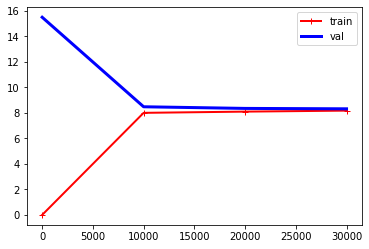

In [ ]:
model=MultiOutputRegressor(Ridge(alpha=101,solver='cholesky'))
plot_learning_curves(model,data1_train,datay_train)

we can see that the validation and training error are close each other when the minibatch length becomes 40000.So let us choose 40000 as our mini batch and train our model 

In [ ]:
def train(model,batch_size,X,Y,length_d):
  #train our model up to integral multiple of batch size index 
  b=[0,batch_size]
  for i in range(length_d):
    model.fit(X[b[0]:b[1]],Y[b[0]:b[1]])
    b[0]=i*batch_size #stays at zero
    b[1]=(i+1)*batch_size #gets updated by integral multiple
  return model

In [ ]:
#Ridge regression with multioutput wrapper
model=MultiOutputRegressor(Ridge(alpha=101,solver='cholesky'))
model=train(model,10000,data1_train,datay_train,2)

In [ ]:
def test(model,X,Y):
  predict=model.predict(X)
  #returns the mean squared error
  error=np.sqrt(mean_squared_error(Y,predict))
  return error

In [ ]:
print(test(model,data1_test,datay_test))

8.546303988835676


Our test error is 8.375 in RMSE

In [ ]:
filename='Ridge_regression'
pickle.dump(model,open(filename,'wb'))


In [ ]:
model=DecisionTreeRegressor()
parameters={'max_depth':range(1,100,10)}
dtree_reg=GridSearchCV (model,parameters,scoring='neg_mean_squared_error',cv=5)
dtree_reg.fit(data1_train,datay_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(1, 100, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=

In [ ]:
print(dtree_reg.best_params_)

{'max_depth': 41}


We have got maximum depth=41 for Decision tree on our Dataset

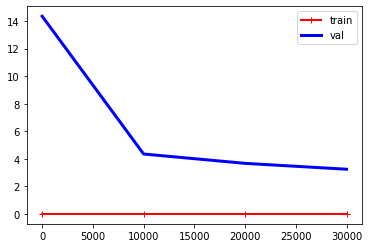

In [ ]:
model=DecisionTreeRegressor(max_depth=41)
plot_learning_curves(model,data1_train,datay_train)

In [ ]:
 model_DT=DecisionTreeRegressor(max_depth=41)
 model_DT=train(model_DT,40000,data1_train,datay_train,2)

In [ ]:
#TESTING OUR DATASET  USING TEST DATAS
#PRINTING THE SQUARE ROOT OF OUR MEAN SQUARED ROOT ERROR
print(test(model_DT,data1_test,datay_test))

2.916572786309261


In [ ]:
filename='DecisionTreeRegressor'
pickle.dump(model_DT,open(filename,'wb'))


**ENSEMBLE MODEL**

In [ ]:
model=RandomForestRegressor(n_estimators=60,max_depth=41,random_state=42)

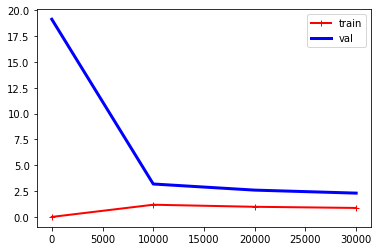

In [ ]:
plot_learning_curves(model,data1_train,datay_train)

Considering the above the learning curve we shall use 40000 as the validation error is still decreasing.

In [ ]:
#TRAIN OUR RANDOMFOREST MODEL
model_rf=train(model,40000,data1_train,datay_train,2)
#TEST OUR TRAINED RANDOMFOREST USING OUR TEST DATASET
#AND PRINT THE SQRT OF MEAN SQUARED ERROR
print(test(model_rf,data1_test,datay_test))

2.0590764595636273


The error we got is 2.05 in RMSE

In [ ]:
filename='RandomForestregressor'
pickle.dump(model_rf,open(filename,'wb'))

**ENSEMBLE-BAGGING**

In [ ]:
from sklearn.ensemble import BaggingRegressor
#LET US USE BAGGING ENSEMBLE OF DECICSION TREES
model_dt=DecisionTreeRegressor(max_depth=41)
bag_regressor_dt=BaggingRegressor(model_dt,n_estimators=100,bootstrap=True,max_samples=5000,n_jobs=-1)
bag_regressor_dt.fit(data1_train,datay_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=41,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=Tru

In [ ]:
print(test(bag_regressor_dt,data1_test,datay_test))

3.144896494817276


In [ ]:
filename='/content/drive/MyDrive/datasets/bag_regressor_dt'
pickle.dump(bag_regressor_dt,open(filename,'wb'))

**XGBOOST**

In [ ]:
import xgboost as xgb

In [ ]:
model=MultiOutputRegressor(xgb.XGBRFRegressor(objective ='reg:squarederror',learning_rate = 0.1, max_depth = 41, alpha = 10, n_estimators =20))

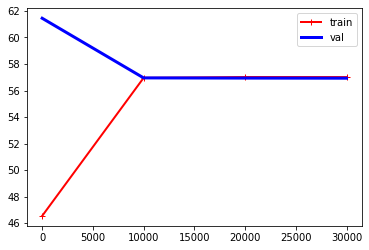

In [ ]:
plot_learning_curves(model,data1_train,datay_train)

In [ ]:
model_xgb=train(model,2000,data1_train,datay_train,20)

In [ ]:
print(test(model_xgb,data1_test,datay_test))

57.10692584501596


Xgb is over model is overfitting

**DEEP LEARNING**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator,load_img
import datetime
import cv2

In [ ]:
model_dl=keras.Sequential()
model_dl.add(keras.layers.Dense(910,activation='linear'))
model_dl.add(keras.layers.Dense(500,activation='sigmoid'))
model_dl.add(keras.layers.Dense(100,activation='linear'))
model_dl.add(keras.layers.Dense(4))

In [ ]:
model_dl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])

In [ ]:
model_dl.fit(data1_train,datay_train,batch_size=500,epochs=10)

Epoch 1/10
81/81 [==============================] - 6s 73ms/step - loss: 1.1953 - mae: 0.7697
Epoch 2/10
81/81 [==============================] - 6s 75ms/step - loss: 1.1625 - mae: 0.7524
Epoch 3/10
81/81 [==============================] - 6s 75ms/step - loss: 1.3526 - mae: 0.8262
Epoch 4/10
81/81 [==============================] - 6s 74ms/step - loss: 1.3908 - mae: 0.8408
Epoch 5/10
81/81 [==============================] - 6s 73ms/step - loss: 1.4874 - mae: 0.8733
Epoch 6/10
81/81 [==============================] - 6s 75ms/step - loss: 1.4200 - mae: 0.8450
Epoch 7/10
81/81 [==============================] - 6s 73ms/step - loss: 1.1942 - mae: 0.7693
Epoch 8/10
81/81 [==============================] - 6s 74ms/step - loss: 1.3329 - mae: 0.8149
Epoch 9/10
81/81 [==============================] - 6s 73ms/step - loss: 1.2555 - mae: 0.7893
Epoch 10/10
81/81 [==============================] - 6s 73ms/step - loss: 1.1017 - mae: 0.7309


In [ ]:
model_dl.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 910)               826280    
_________________________________________________________________
dense_71 (Dense)             (None, 500)               455500    
_________________________________________________________________
dense_72 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_73 (Dense)             (None, 4)                 404       
Total params: 1,332,284
Trainable params: 1,332,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pred=model_dl.predict(data1_test)

In [ ]:
print(np.sqrt(mean_squared_error(pred,datay_test)))

2.345010504280912


In [ ]:
model_dl.save("/content/drive/MyDrive/datasets/model_dl")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datasets/model_dl/assets


**CONCLUSION**

1. From the trained models Randomforest has better performance and decisiontree and bagging with decision tree are the next ones.


**NOTE THAT(FOR DEPLOYEMNT)**

1. The distance features(Distance,Distance_x,Distance_y) are dropped form the dataset and are used to create another feature with thee clusters of distance
2. We have used StandardScaler from sklearn module for features like(Latitude,Longitude and Speed).
